# Explore LIDC-IDRI metadata

## Imports and configuration

In [1]:
from pathlib import Path

import pylidc as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import pydicom as dicom
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [12, 8]

LIDC_DIR = Path("/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/")
DICOM_DIR = LIDC_DIR / "LIDC-IDRI"

## Load metadata

In [2]:
patients = pd.read_csv(DICOM_DIR/"lidc_patient_meta.csv", index_col="PatientID")
print(patients.shape)
scans = pd.read_csv(DICOM_DIR/"lidc_scan_meta.csv")
print(scans.shape)
nodules = pd.read_csv(DICOM_DIR/"lidc_nodule_meta.csv")
print(nodules.shape)

(157, 3)
(1018, 22)
(2651, 17)


## Explore metadata at the scan level

### Combine patient and scan data

In [3]:
scans = scans.join(patients, on="PatientID")

In [4]:
scans.shape

(1018, 25)

In [5]:
scans.dtypes

StudyID                               object
SeriesID                              object
PatientID                             object
SliceThickness                       float64
SliceSpacing                         float64
PixelSpacing                         float64
ContrastUsed                            bool
ImagePositionPatient                  object
ImageOrientationPatient               object
Rows                                   int64
Columns                                int64
RescaleIntercept                     float64
RescaleSlope                         float64
WindowCenter                          object
WindowWidth                           object
BitsAllocated                          int64
PixelRepresentation                    int64
Manufacturer                          object
ManufacturerModelName                 object
NumAnnotations                         int64
NumNodules                             int64
MaxMalignancy                        float64
Diagnosis 

### Explore patient data

In [6]:
len(pd.unique(scans.PatientID))

1010

In [7]:
meta = pd.read_csv(DICOM_DIR/"lidc_dicom_meta_raw.csv")

In [33]:
sexes = pd.Series([p[1] for p in meta.groupby("PatientID")["PatientSex"].value_counts().index])
print(len(sexes))
print(sexes.value_counts(normalize=True))

286
F    0.51049
M    0.48951
dtype: float64


### Plot nodule distributions

In [6]:
scans.NumNodules.describe()

count    1018.000000
mean        2.604126
std         2.659182
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        23.000000
Name: NumNodules, dtype: float64

<AxesSubplot:title={'center':'Number of nodules per patient'}, ylabel='Frequency'>

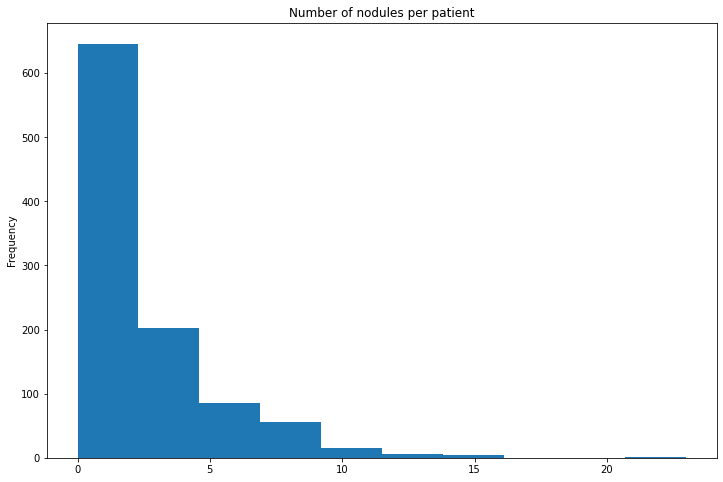

In [28]:
scans.NumNodules.plot(kind="hist", title="Number of nodules per patient")

In [8]:
no_nods = scans.query('NumNodules == 0')
no_anns = scans.query('NumAnnotations == 0')
anns_wo_nods = scans.query('(NumNodules == 0) & (NumAnnotations > 0)')

print(f"Found {len(no_nods)} scans without nodules.")
print(f"Found {len(no_anns)} scans without annotations.")
print(f"Found {len(anns_wo_nods)} scans with annotations, but without clustered nodules.")

Found 135 scans without nodules.
Found 135 scans without annotations.
Found 0 scans with annotations, but without clustered nodules.


In [9]:
anns_per_nod = (scans.NumAnnotations/scans.NumNodules)
anns_per_nod.describe()

count    883.000000
mean       2.720409
std        0.968871
min        1.000000
25%        2.000000
50%        2.666667
75%        3.500000
max        8.000000
dtype: float64

<AxesSubplot:title={'center':'Number of annotators per nodule'}, ylabel='Frequency'>

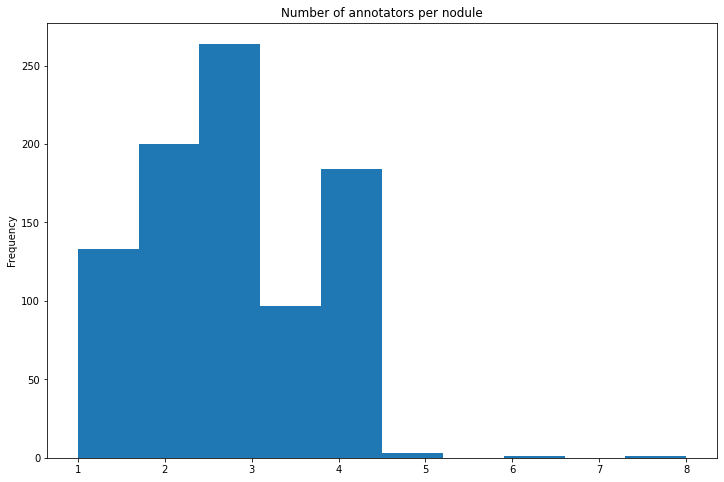

In [29]:
anns_per_nod.plot(kind="hist", title="Number of annotators per nodule")

### Plot classification distribution

Remember the codes for malignancy scores (see [pylidc docs](https://pylidc.github.io/annotation.html)):

- 1 = ‘Highly Unlikely’
- 2 = ‘Moderately Unlikely’
- 3 = ‘Indeterminate’
- 4 = ‘Moderately Suspicious’
- 5 = ‘Highly Suspicious’

We add 0 for 'no nodules found'.

In [11]:
scans.MaxMalignancy = scans.MaxMalignancy.replace(to_replace=np.nan, value=0)

<AxesSubplot:title={'center':'Maximum malignancy values per scan'}>

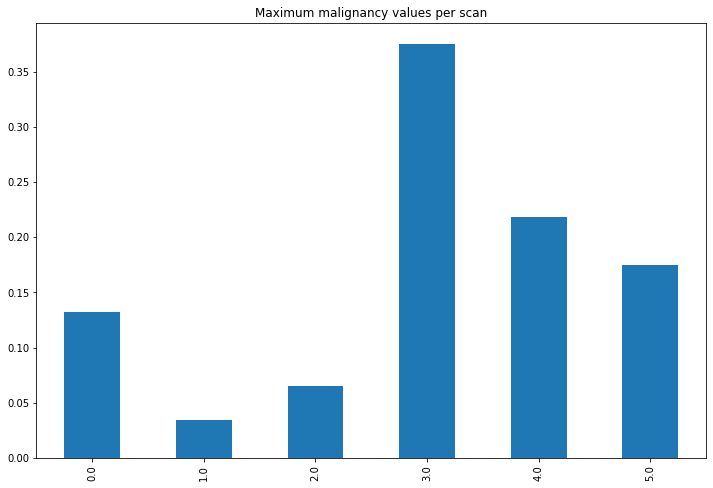

In [12]:
scans.MaxMalignancy.value_counts(normalize=True).plot(kind="bar", title="Maximum malignancy values per scan")

### Plot diagnosis distribution

Codes for diagnosis variable:

- 0 = Unknown
- 1 = benign or non-malignant disease
- 2 = malignant, primary lung cancer
- 3 = malignant metastatic

<AxesSubplot:title={'center':'Diagnoses for subsample of 277 patients'}>

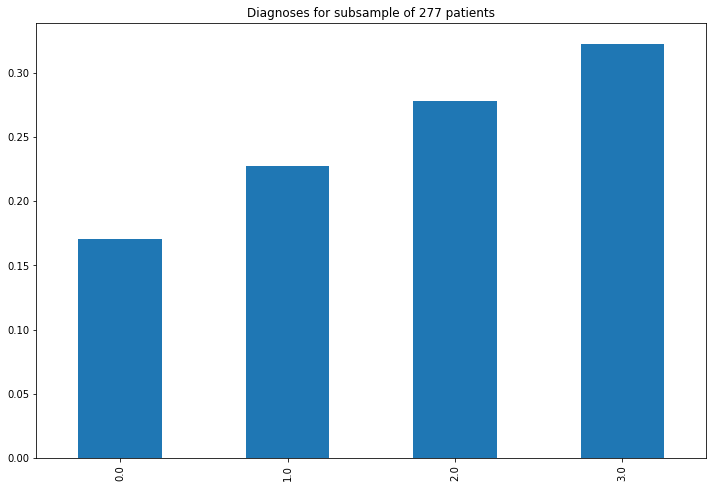

In [13]:
num_diags = int(scans.Diagnosis.sum())
scans.Diagnosis.value_counts(normalize=True).plot(kind="bar", title=f"Diagnoses for subsample of {num_diags} patients")

### Plot CT scanner distribution

<AxesSubplot:title={'center':'CT Device Manufacturer'}>

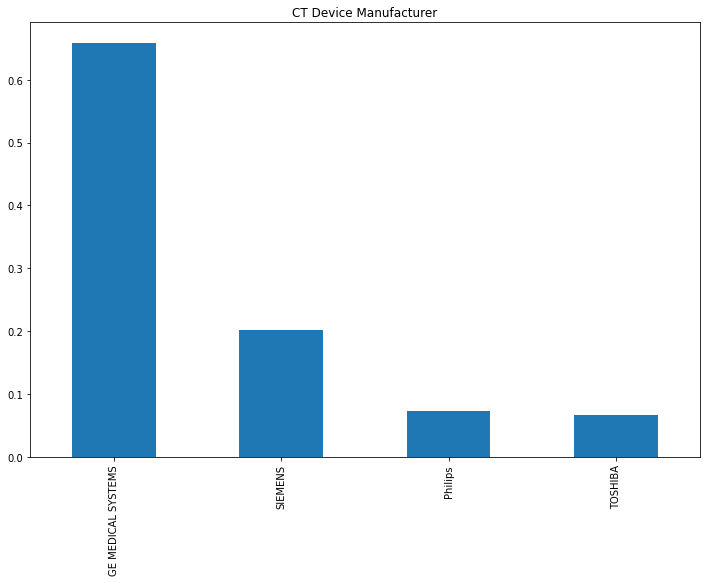

In [30]:
scans.Manufacturer.value_counts(normalize=True).plot(kind="bar", title="CT Device Manufacturer")

<AxesSubplot:title={'center':'CT Device Model'}, xlabel='Manufacturer,ManufacturerModelName'>

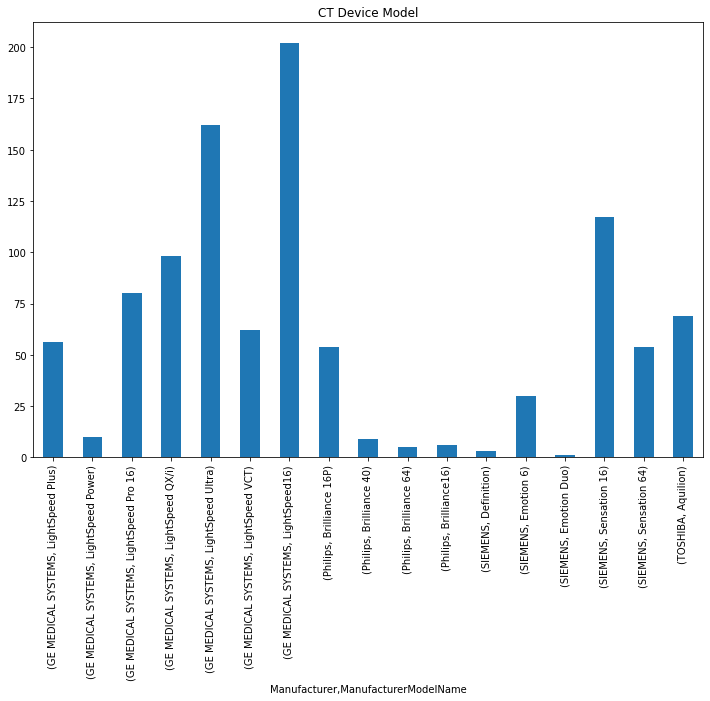

In [31]:
scans.groupby(["Manufacturer", "ManufacturerModelName"]).count()["SeriesID"].plot(kind="bar", title="CT Device Model")

## Explore metadata at the nodule level

In [34]:
nodules.dtypes

PatientID             object
StudyID               object
SeriesID              object
NoduleID               int64
NumAnnotations         int64
Diameter             float64
SurfaceArea          float64
Volume               float64
Malignancy             int64
Texture                int64
Spiculation            int64
Lobulation             int64
Margin                 int64
Sphericity             int64
Calcification          int64
InternalStructure      int64
Subtlety               int64
dtype: object

### Explore nodule sizes

count    2651.000000
mean       10.161367
std         6.733856
min         2.585936
25%         6.128319
50%         7.818802
75%        11.144932
max        49.944618
Name: Diameter, dtype: float64


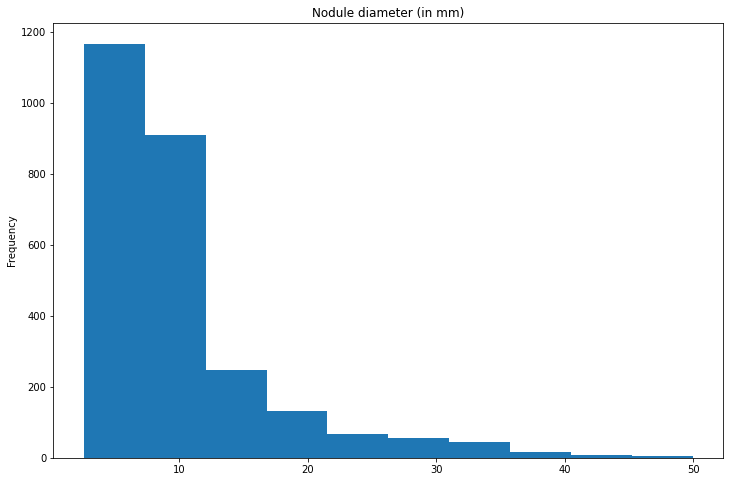

In [17]:
print(nodules.Diameter.describe())
nodules.Diameter.plot(kind="hist", title="Nodule diameter (in mm)")
plt.show()

count    2651.000000
mean      375.657790
std       695.361970
min        13.761003
25%        84.093594
50%       137.672610
75%       299.769071
max      9026.567042
Name: SurfaceArea, dtype: float64


<AxesSubplot:title={'center':'Nodule area (in mm^2)'}, ylabel='Frequency'>

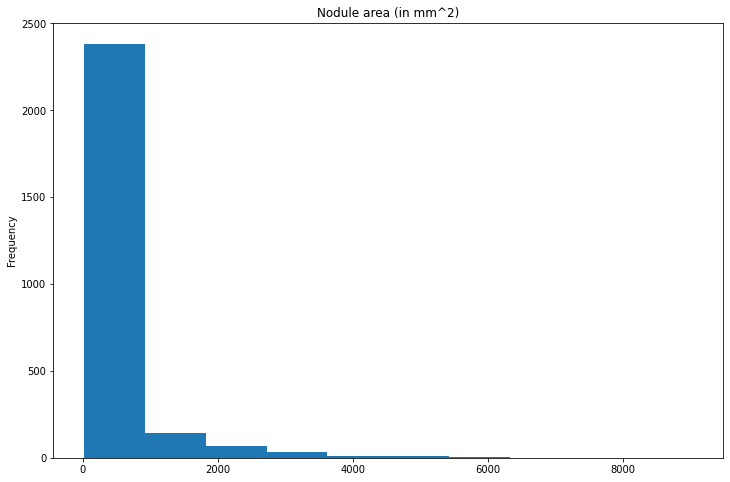

In [19]:
print(nodules.SurfaceArea.describe())
nodules.SurfaceArea.plot(kind="hist", title="Nodule area (in mm^2)")

count     2651.000000
mean       630.330489
std       1779.426900
min          8.544922
25%         63.627390
50%        122.416228
75%        323.061775
max      31112.197113
Name: Volume, dtype: float64


<AxesSubplot:title={'center':'Nodule volume (in mm^3)'}, ylabel='Frequency'>

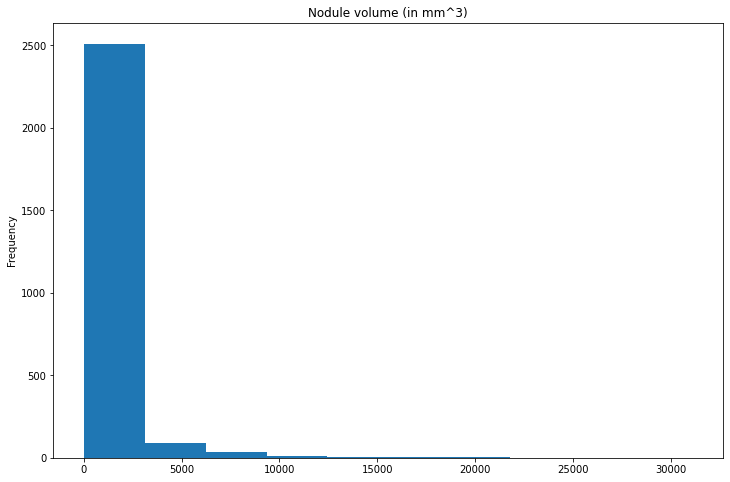

In [20]:
print(nodules.Volume.describe())
nodules.Volume.plot(kind="hist", title="Nodule volume (in mm^3)")

### Explore nodule annotations

See [pylidc docs](https://pylidc.github.io/annotation.html) for information about annotation coding.

In [22]:
?pl.Annotation

In [26]:
ann_cols = nodules.columns[-9:]

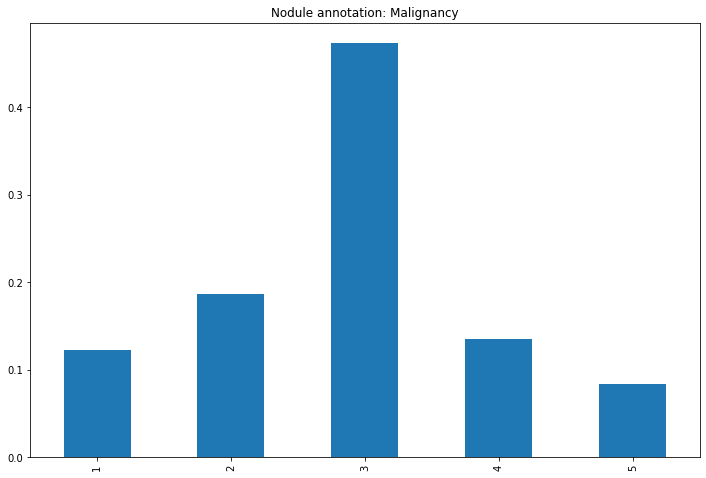

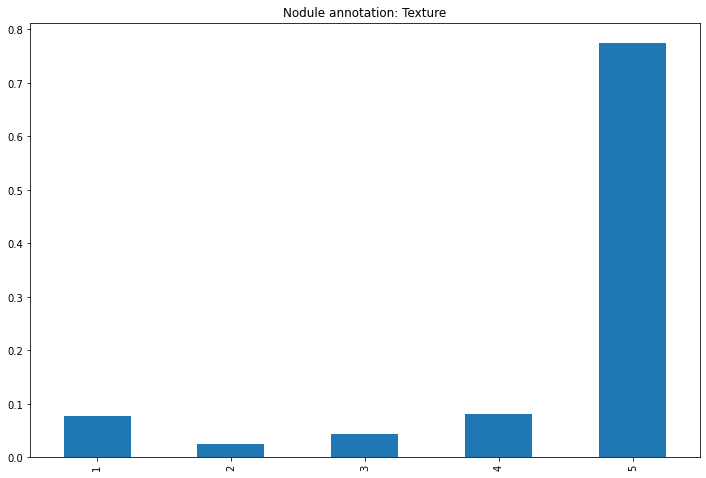

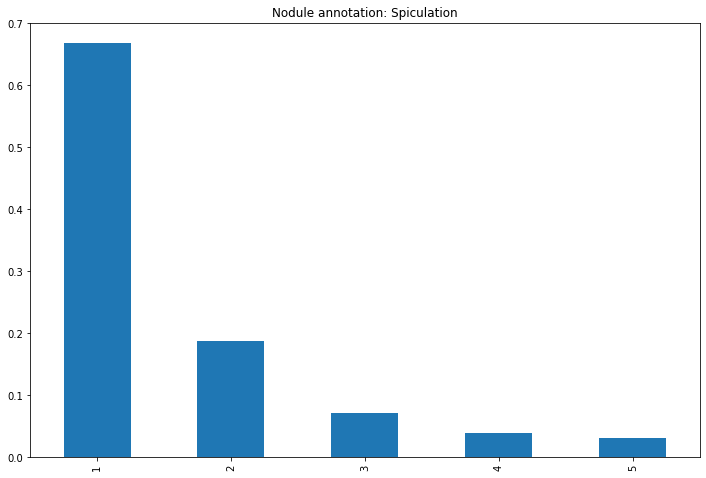

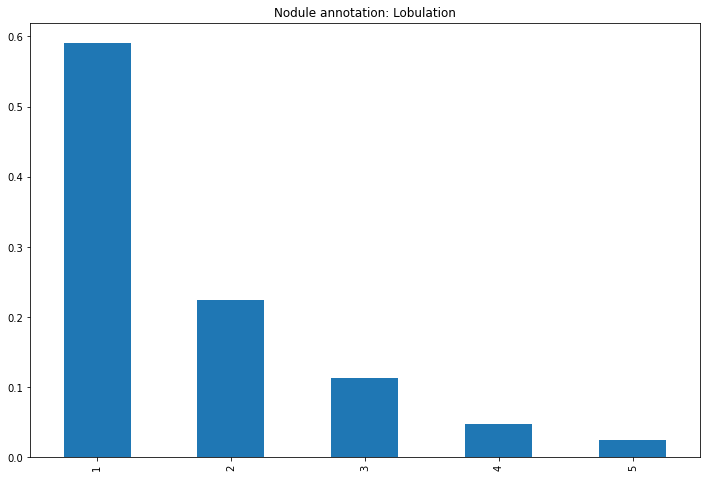

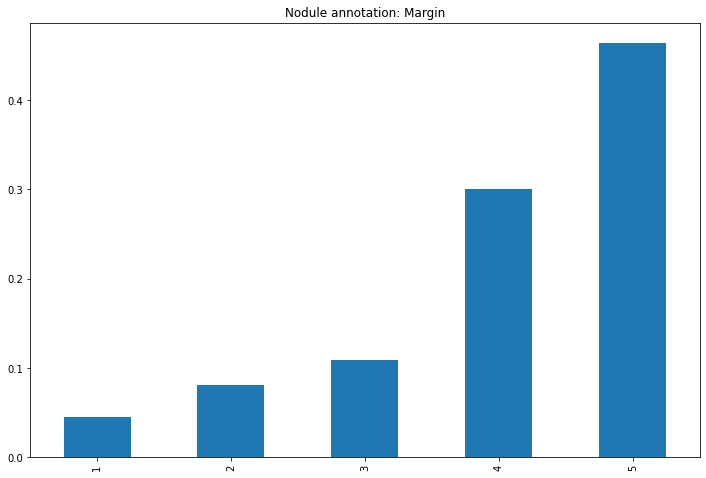

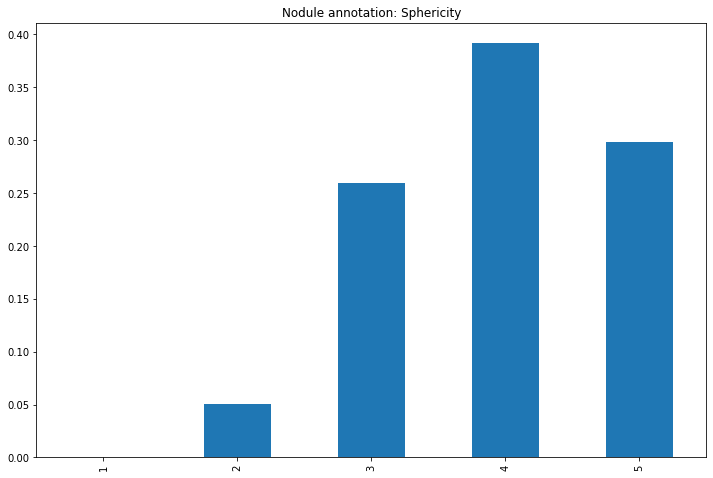

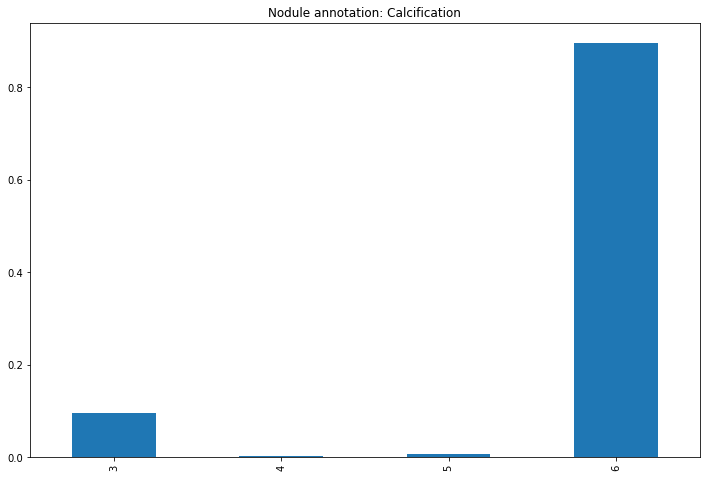

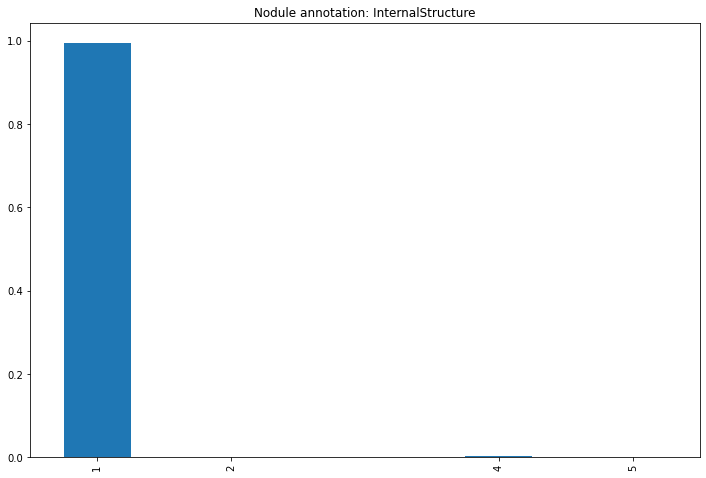

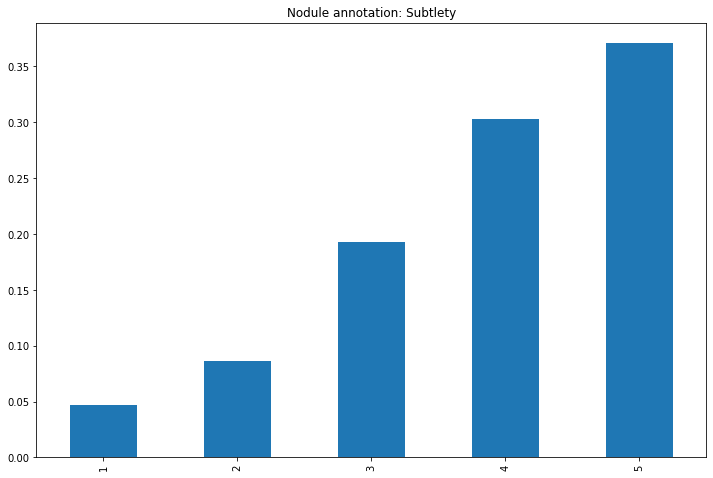

In [27]:
for col in ann_cols:
    nodules[col].value_counts(normalize=True).plot(kind="bar")
    plt.title(f"Nodule annotation: {col}")
    plt.show()

In [40]:
malig = (nodules.Malignancy > 3)
print(malig.value_counts(normalize=True))
print(malig.value_counts())

False    0.781215
True     0.218785
Name: Malignancy, dtype: float64
False    2071
True      580
Name: Malignancy, dtype: int64
